# Use Model Context Protocol (MCP) as tools with Strands Agent

## Overview
The [Model Context Protocol (MCP)](https://modelcontextprotocol.io/introduction) is an open protocol that standardizes how applications provide context to Large Language Models (LLMs). Strands AI SDK integrates with MCP to extend agent capabilities through external tools and services.

MCP enables communication between agents and MCP servers that provide additional tools. The Strands Agent SDK includes built-in support for connecting to MCP servers and using their tools.

In this example we will show you how to use MCP tools on your Strands Agent. We will use the [AWS Documentation MCP server](https://awslabs.github.io/mcp/servers/aws-documentation-mcp-server/) which provides tools to access AWS documentation, search for content, and get recommendations. This MCP server has 3 main features:

- **Read Documentation**: Fetch and convert AWS documentation pages to markdown format
- **Search Documentation**: Search AWS documentation using the official search API
- **Recommendations**: Get content recommendations for AWS documentation pages



## Agent Details
<div style="float: left; margin-right: 20px;">
    
|Feature             |Description                                        |
|--------------------|---------------------------------------------------|
|Feature used        |MCP Tools                                          |
|Agent Structure     |Single agent architecture                          |

</div>

## Architecture

<div style="text-align:center">
    <img src="images/architecture.png" width="65%" />
</div>

## Key Features
* **Single agent architecture**: this example creates a single agent that interacts with MCP tools
* **MCP tools**: Integration of MCP tools with your agent

## Setup and prerequisites

### Prerequisites
* Python 3.10+
* AWS account
* Anthropic Claude 3.7 enabled on Amazon Bedrock

Let's now install the requirement packages for our Strands Agent agent

In [1]:
# installing pre-requisites
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 166.5 MB/s  0:00:00


### Importing dependency packages

Now let's import the dependency packages

In [2]:
import threading
import time
from datetime import timedelta

from mcp import StdioServerParameters, stdio_client
from mcp.client.streamable_http import streamablehttp_client
from mcp.server import FastMCP
from strands import Agent
from strands.tools.mcp import MCPClient

### Connect to MCP server using stdio transport

[Transports](https://modelcontextprotocol.io/specification/2025-03-26/basic/transports) in MCP provide the foundations for communication between clients and servers. It handles the underlying mechanics of how messages are sent and received. At the moment there are three standards transport implementations built-in in MCP:

- **Standard Input/Output (stdio)**: enables communication through standard input and output streams. It is particularly useful for local integrations and command-line tools

  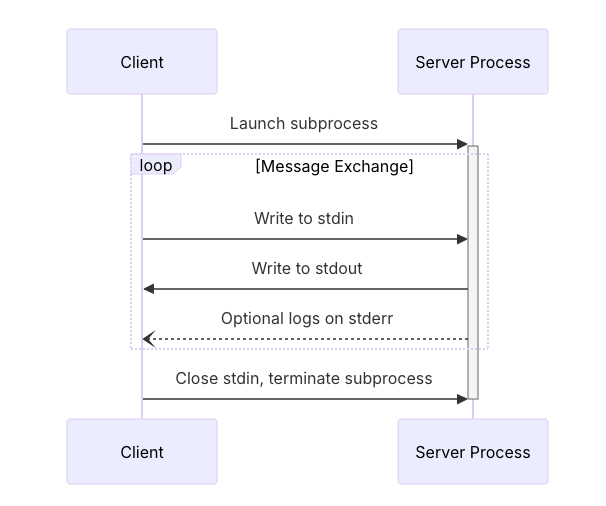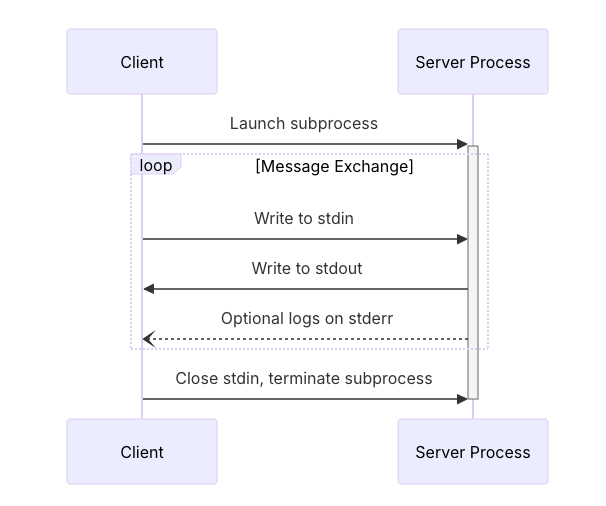
  
- **Streamable HTTP**: this replaces the HTTP+SSE transport from previous protocol version. In the Streamable HTTP transport, the server operates as an independent process that can handle multiple client connections. This transport uses HTTP POST and GET requests. Server can optionally make use of Server-Sent Events (SSE) to stream multiple server messages. This permits basic MCP servers, as well as more feature-rich servers supporting streaming and server-to-client notifications and requests.

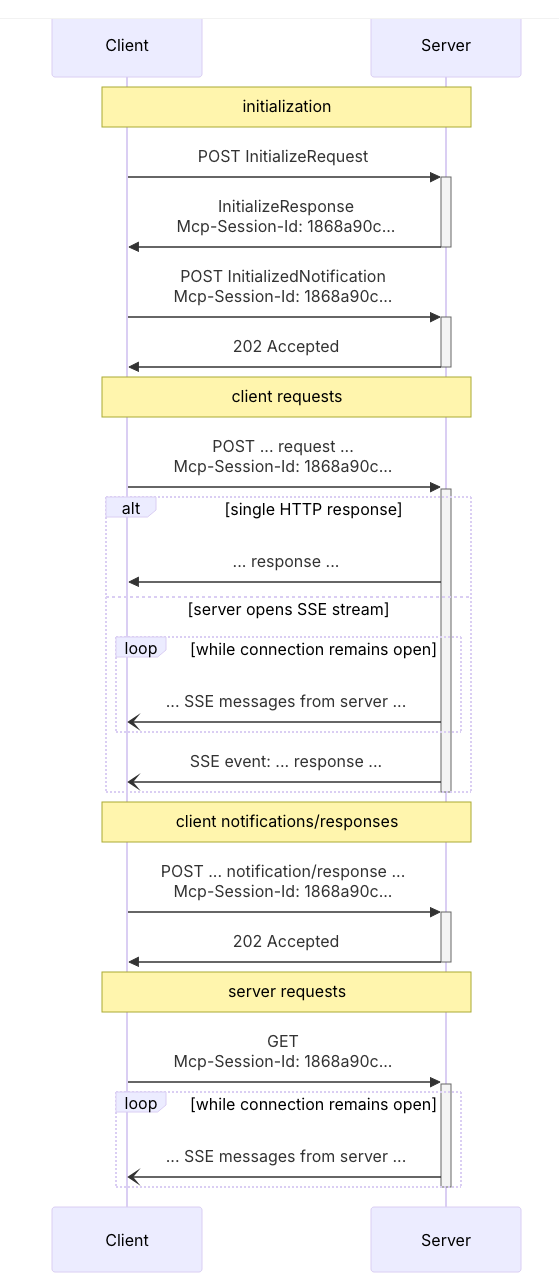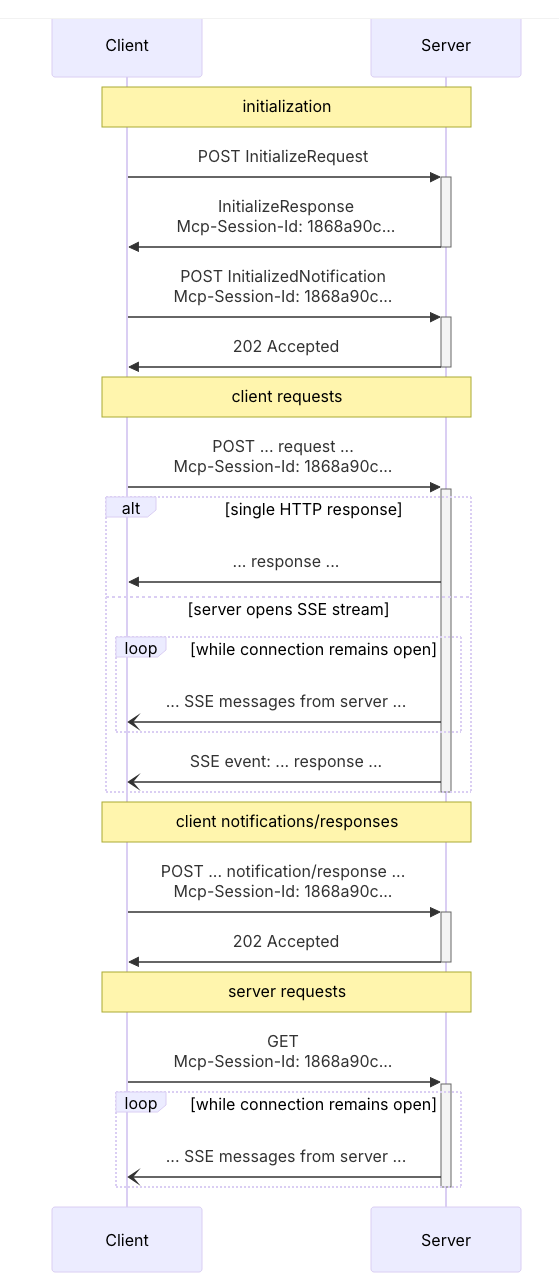

- **SSE**: legacy transport for HTTP-based MCP servers that use Server-Sent Events transport  

Overall, you should use stdio for building command-line tools, implementing local integrations and working with shell scripts. You should use Streamable HTTP transports when you need a flexible and efficient way for AI agents to communicate with tools and services, especially when dealing with stateless communication or when minimizing resource usage is crucial.

You can also use **custom transports** implementation for your specific needs. 




## Standard Input/Output use-cases:

- Building command-line tools
- Implementing local integrations
- Working with shell scripts

## Streamtable Transport use-cases:

- Flexible and efficient communication of AI agents with tools and services
- Stateless communication
- Minimization of resource usage
  
You can also use custom transports implementation for your specific needs.

Let's now connect to the MCP server using stdio transport. First of all, we will use the class `MCPClient` to connect to the [AWS Documentation MCP Server](https://awslabs.github.io/mcp/servers/aws-documentation-mcp-server/). This server provides tools to access AWS documentation, search for content, and get recommendations.

In [3]:
# Connect to an MCP server using stdio transport
stdio_mcp_client = MCPClient(
    lambda: stdio_client(
        StdioServerParameters(
            command="uvx", args=["awslabs.aws-documentation-mcp-server@latest"]
        )
    )
)

#### Setup agent configuration and invoke it

Next we will set our agent configuration using the tools from the `stdio_mcp_client` object we just created. To do so, we need to list the tools available in the MCP server. We can use the `list_tools_sync` method for it. 

After that, we will ask a question to our agent.

In [4]:
# Create an agent with MCP tools
with stdio_mcp_client:
    # Get the tools from the MCP server
    tools = stdio_mcp_client.list_tools_sync()

    # Create an agent with these tools
    agent = Agent(
        model="us.anthropic.claude-3-7-sonnet-20250219-v1:0",
        tools=tools)

    response = agent("What is Amazon Bedrock pricing model. Be concise.")

I'll get the Amazon Bedrock pricing information for you. Let me search the AWS documentation for the most up-to-date pricing model.
Tool #1: search_documentation
Let me get the detailed pricing information from the main pricing page:
Tool #2: read_documentation
Let me get more specific information about the pricing model:
Tool #3: read_documentation
Based on the AWS documentation, here's a concise overview of Amazon Bedrock's pricing model:

# Amazon Bedrock Pricing Model

1. **Pay-as-you-go basis**: You pay only for what you use with no upfront commitments.

2. **Token-based pricing**: Costs are calculated based on:
   - Volume of input tokens processed
   - Volume of output tokens generated
   - Specific foundation model used

3. **Provisioned Throughput option**:
   - Purchase dedicated capacity for higher throughput at a fixed cost
   - Billed hourly based on:
     - Selected model
     - Number of Model Units (MUs) purchased
     - Commitment duration (no commitment, 1 month, or 6

### Connect to MCP server using Streamable HTTP

Let's now connect to the MCP server using Streamable HTTP transport. First let's start a simple MCP server using Streamable HTTP transport. 

For this example we will create our own MCP server. The architecture will look as following

<div style="text-align:center">
    <img src="images/architecture_2.png" width="65%" />
</div>

In [5]:
# Create an MCP server
mcp = FastMCP("Calculator Server")

# Define a tool

@mcp.tool(description="Calculator tool which performs calculations")
def calculator(x: int, y: int) -> int:
    return x + y


@mcp.tool(description="This is a long running tool")
def long_running_tool(name: str) -> str:
    time.sleep(25)
    return f"Hello {name}"


def main():
    mcp.run(transport="streamable-http", mount_path="mcp")

Let's now start a thread with the `streamable-http` server

In [6]:
thread = threading.Thread(target=main)
thread.start()

INFO:     Started server process [25513]
INFO:     Waiting for application startup.


[11/28/25 12:51:01] INFO     StreamableHTTP session manager started                  ]8;id=903168;file:///opt/conda/lib/python3.12/site-packages/mcp/server/streamable_http_manager.py\streamable_http_manager.py]8;;\:]8;id=487535;file:///opt/conda/lib/python3.12/site-packages/mcp/server/streamable_http_manager.py#110\110]8;;\

INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


#### Integrating Streamable HTTP client with Agent

Now let's use `streamablehttp_client` integrate this server with a simple agent. 

In [7]:
def create_streamable_http_transport():
    return streamablehttp_client("http://localhost:8000/mcp")


streamable_http_mcp_client = MCPClient(create_streamable_http_transport)

#### Setup agent configuration and invoke it

Next we will set our agent configuration using the tools from the `streamable_http_mcp_client` object we just created. To do so, we need to list the tools available in the MCP server. We can use the `list_tools_sync` method for it. 

After that, we will ask a question to our agent.

In [8]:
with streamable_http_mcp_client:
    tools = streamable_http_mcp_client.list_tools_sync()

    agent = Agent(
        model="us.anthropic.claude-3-7-sonnet-20250219-v1:0",
        tools=tools)

    response = str(agent("What is 2 + 2?"))

[11/28/25 12:52:17] INFO     Created new transport with session ID:                  ]8;id=87015;file:///opt/conda/lib/python3.12/site-packages/mcp/server/streamable_http_manager.py\streamable_http_manager.py]8;;\:]8;id=421760;file:///opt/conda/lib/python3.12/site-packages/mcp/server/streamable_http_manager.py#233\233]8;;\
                             c481f42907444f1982bea90fd7050241                                                      

INFO:     127.0.0.1:42246 - "POST /mcp HTTP/1.1" 200 OK


                    INFO     HTTP Request: POST http://localhost:8000/mcp "HTTP/1.1 200 OK"         ]8;id=268711;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=952636;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py#1740\1740]8;;\

                    INFO     Received session ID: c481f42907444f1982bea90fd7050241           ]8;id=36001;file:///opt/conda/lib/python3.12/site-packages/mcp/client/streamable_http.py\streamable_http.py]8;;\:]8;id=546984;file:///opt/conda/lib/python3.12/site-packages/mcp/client/streamable_http.py#134\134]8;;\

                    INFO     Negotiated protocol version: 2025-06-18                         ]8;id=424953;file:///opt/conda/lib/python3.12/site-packages/mcp/client/streamable_http.py\streamable_http.py]8;;\:]8;id=493136;file:///opt/conda/lib/python3.12/site-packages/mcp/client/streamable_http.py#146\146]8;;\

INFO:     127.0.0.1:42254 - "POST /mcp HTTP/1.1" 202 Accepted
INFO:     127.0.0.1:42260 - "GET /mcp HTTP/1.1" 200 OK


[11/28/25 12:52:18] INFO     HTTP Request: POST http://localhost:8000/mcp "HTTP/1.1 202 Accepted"   ]8;id=239084;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=823380;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py#1740\1740]8;;\

                    INFO     HTTP Request: GET http://localhost:8000/mcp "HTTP/1.1 200 OK"          ]8;id=395894;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=385243;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py#1740\1740]8;;\

INFO:     127.0.0.1:42272 - "POST /mcp HTTP/1.1" 200 OK


                    INFO     Processing request of type ListToolsRequest                              ]8;id=127204;file:///opt/conda/lib/python3.12/site-packages/mcp/server/lowlevel/server.py\server.py]8;;\:]8;id=928829;file:///opt/conda/lib/python3.12/site-packages/mcp/server/lowlevel/server.py#674\674]8;;\

                    INFO     HTTP Request: POST http://localhost:8000/mcp "HTTP/1.1 200 OK"         ]8;id=909396;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=114824;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py#1740\1740]8;;\

I can help you calculate 2 + 2 using the calculator tool.
Tool #1: calculator
INFO:     127.0.0.1:39430 - "POST /mcp HTTP/1.1" 200 OK


[11/28/25 12:52:21] INFO     Processing request of type CallToolRequest                               ]8;id=178808;file:///opt/conda/lib/python3.12/site-packages/mcp/server/lowlevel/server.py\server.py]8;;\:]8;id=63960;file:///opt/conda/lib/python3.12/site-packages/mcp/server/lowlevel/server.py#674\674]8;;\

                    INFO     HTTP Request: POST http://localhost:8000/mcp "HTTP/1.1 200 OK"         ]8;id=10145;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=270470;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py#1740\1740]8;;\

The result of 2 + 2 is 4.

[11/28/25 12:52:22] INFO     Terminating session: c481f42907444f1982bea90fd7050241           ]8;id=465713;file:///opt/conda/lib/python3.12/site-packages/mcp/server/streamable_http.py\streamable_http.py]8;;\:]8;id=666290;file:///opt/conda/lib/python3.12/site-packages/mcp/server/streamable_http.py#646\646]8;;\

INFO:     127.0.0.1:39438 - "DELETE /mcp HTTP/1.1" 200 OK


                    INFO     HTTP Request: DELETE http://localhost:8000/mcp "HTTP/1.1 200 OK"       ]8;id=532794;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=83630;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py#1740\1740]8;;\

### Direct Tool Invocation

While tools are typically invoked by the agent based on user requests, ### you can also call MCP tools directly ###. This can be useful for workflow scenarios where you orchestrate multiple tools together.

In [9]:
query = {"x": 10, "y": 20}

with streamable_http_mcp_client:
    # direct tool invocation
    result = streamable_http_mcp_client.call_tool_sync(
        tool_use_id="tool-123", name="calculator", arguments=query
    )

    # Process the result
    print(f"Calculation result: {result['content'][0]['text']}")

[11/28/25 12:54:31] INFO     Created new transport with session ID:                  ]8;id=397172;file:///opt/conda/lib/python3.12/site-packages/mcp/server/streamable_http_manager.py\streamable_http_manager.py]8;;\:]8;id=985168;file:///opt/conda/lib/python3.12/site-packages/mcp/server/streamable_http_manager.py#233\233]8;;\
                             e0e8e19346ce4a59a36584e5d29925bc                                                      

INFO:     127.0.0.1:34654 - "POST /mcp HTTP/1.1" 200 OK


                    INFO     HTTP Request: POST http://localhost:8000/mcp "HTTP/1.1 200 OK"         ]8;id=723871;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=578558;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py#1740\1740]8;;\

                    INFO     Received session ID: e0e8e19346ce4a59a36584e5d29925bc           ]8;id=956779;file:///opt/conda/lib/python3.12/site-packages/mcp/client/streamable_http.py\streamable_http.py]8;;\:]8;id=328559;file:///opt/conda/lib/python3.12/site-packages/mcp/client/streamable_http.py#134\134]8;;\

                    INFO     Negotiated protocol version: 2025-06-18                         ]8;id=648618;file:///opt/conda/lib/python3.12/site-packages/mcp/client/streamable_http.py\streamable_http.py]8;;\:]8;id=27144;file:///opt/conda/lib/python3.12/site-packages/mcp/client/streamable_http.py#146\146]8;;\

INFO:     127.0.0.1:34674 - "GET /mcp HTTP/1.1" 200 OK
INFO:     127.0.0.1:34658 - "POST /mcp HTTP/1.1" 202 Accepted


                    INFO     HTTP Request: GET http://localhost:8000/mcp "HTTP/1.1 200 OK"          ]8;id=332478;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=897028;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py#1740\1740]8;;\

                    INFO     HTTP Request: POST http://localhost:8000/mcp "HTTP/1.1 202 Accepted"   ]8;id=874047;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=278984;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py#1740\1740]8;;\

INFO:     127.0.0.1:34680 - "POST /mcp HTTP/1.1" 200 OK


                    INFO     HTTP Request: POST http://localhost:8000/mcp "HTTP/1.1 200 OK"         ]8;id=803948;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=307759;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py#1740\1740]8;;\

                    INFO     Processing request of type CallToolRequest                               ]8;id=110554;file:///opt/conda/lib/python3.12/site-packages/mcp/server/lowlevel/server.py\server.py]8;;\:]8;id=701683;file:///opt/conda/lib/python3.12/site-packages/mcp/server/lowlevel/server.py#674\674]8;;\

INFO:     127.0.0.1:34692 - "POST /mcp HTTP/1.1" 200 OK


                    INFO     HTTP Request: POST http://localhost:8000/mcp "HTTP/1.1 200 OK"         ]8;id=412198;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=758921;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py#1740\1740]8;;\

                    INFO     Processing request of type ListToolsRequest                              ]8;id=514392;file:///opt/conda/lib/python3.12/site-packages/mcp/server/lowlevel/server.py\server.py]8;;\:]8;id=808856;file:///opt/conda/lib/python3.12/site-packages/mcp/server/lowlevel/server.py#674\674]8;;\

Calculation result: 30


                    INFO     Terminating session: e0e8e19346ce4a59a36584e5d29925bc           ]8;id=484954;file:///opt/conda/lib/python3.12/site-packages/mcp/server/streamable_http.py\streamable_http.py]8;;\:]8;id=691872;file:///opt/conda/lib/python3.12/site-packages/mcp/server/streamable_http.py#646\646]8;;\

INFO:     127.0.0.1:34694 - "DELETE /mcp HTTP/1.1" 200 OK


                    INFO     HTTP Request: DELETE http://localhost:8000/mcp "HTTP/1.1 200 OK"       ]8;id=11840;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=449062;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py#1740\1740]8;;\

You can optionally also provide `read_timeout_seconds` while calling an MCP server tool to avoid it running for too long

In [10]:
with streamable_http_mcp_client:
    try:
        result = streamable_http_mcp_client.call_tool_sync(
            tool_use_id="tool-123",
            name="long_running_tool",
            arguments={"name": "Amazon"},
            read_timeout_seconds=timedelta(seconds=30),
        )

        if result["status"] == "error":
            print(f"Tool execution failed: {result['content'][0]['text']}")
        else:
            print(f"Tool execution succeeded: {result['content'][0]['text']}")
    except Exception as e:
        print(f"Tool call timed out or failed: {str(e)}")

[11/28/25 12:54:45] INFO     Created new transport with session ID:                  ]8;id=120254;file:///opt/conda/lib/python3.12/site-packages/mcp/server/streamable_http_manager.py\streamable_http_manager.py]8;;\:]8;id=887373;file:///opt/conda/lib/python3.12/site-packages/mcp/server/streamable_http_manager.py#233\233]8;;\
                             2e6a0cf071744aaab9057f8f9e5ba230                                                      

INFO:     127.0.0.1:36578 - "POST /mcp HTTP/1.1" 200 OK


                    INFO     HTTP Request: POST http://localhost:8000/mcp "HTTP/1.1 200 OK"         ]8;id=283892;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=317244;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py#1740\1740]8;;\

                    INFO     Received session ID: 2e6a0cf071744aaab9057f8f9e5ba230           ]8;id=453465;file:///opt/conda/lib/python3.12/site-packages/mcp/client/streamable_http.py\streamable_http.py]8;;\:]8;id=990796;file:///opt/conda/lib/python3.12/site-packages/mcp/client/streamable_http.py#134\134]8;;\

                    INFO     Negotiated protocol version: 2025-06-18                         ]8;id=452344;file:///opt/conda/lib/python3.12/site-packages/mcp/client/streamable_http.py\streamable_http.py]8;;\:]8;id=426974;file:///opt/conda/lib/python3.12/site-packages/mcp/client/streamable_http.py#146\146]8;;\

INFO:     127.0.0.1:36602 - "GET /mcp HTTP/1.1" 200 OK
INFO:     127.0.0.1:36590 - "POST /mcp HTTP/1.1" 202 Accepted


                    INFO     HTTP Request: GET http://localhost:8000/mcp "HTTP/1.1 200 OK"          ]8;id=559247;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=842820;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py#1740\1740]8;;\

                    INFO     HTTP Request: POST http://localhost:8000/mcp "HTTP/1.1 202 Accepted"   ]8;id=495128;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=820970;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py#1740\1740]8;;\

INFO:     127.0.0.1:36612 - "POST /mcp HTTP/1.1" 200 OK


                    INFO     Processing request of type CallToolRequest                               ]8;id=326254;file:///opt/conda/lib/python3.12/site-packages/mcp/server/lowlevel/server.py\server.py]8;;\:]8;id=433327;file:///opt/conda/lib/python3.12/site-packages/mcp/server/lowlevel/server.py#674\674]8;;\

                    INFO     HTTP Request: POST http://localhost:8000/mcp "HTTP/1.1 200 OK"         ]8;id=281214;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=685851;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py#1740\1740]8;;\

INFO:     127.0.0.1:39734 - "POST /mcp HTTP/1.1" 200 OK


[11/28/25 12:55:10] INFO     Processing request of type ListToolsRequest                              ]8;id=249458;file:///opt/conda/lib/python3.12/site-packages/mcp/server/lowlevel/server.py\server.py]8;;\:]8;id=808833;file:///opt/conda/lib/python3.12/site-packages/mcp/server/lowlevel/server.py#674\674]8;;\

                    INFO     HTTP Request: POST http://localhost:8000/mcp "HTTP/1.1 200 OK"         ]8;id=237951;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=781354;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py#1740\1740]8;;\

Tool execution succeeded: Hello Amazon


                    INFO     Terminating session: 2e6a0cf071744aaab9057f8f9e5ba230           ]8;id=887065;file:///opt/conda/lib/python3.12/site-packages/mcp/server/streamable_http.py\streamable_http.py]8;;\:]8;id=203550;file:///opt/conda/lib/python3.12/site-packages/mcp/server/streamable_http.py#646\646]8;;\

INFO:     127.0.0.1:39740 - "DELETE /mcp HTTP/1.1" 200 OK


                    INFO     HTTP Request: DELETE http://localhost:8000/mcp "HTTP/1.1 200 OK"       ]8;id=185238;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=348293;file:///opt/conda/lib/python3.12/site-packages/httpx/_client.py#1740\1740]8;;\

### Interacting with multiple MCP servers

With Strands Agents you can also interact with multiple MCP servers using the same agent and configure tools setups such as the max number of tools that can be used in parallel (`max_parallel_tools`). Let's create a new agent to showcase this configuration:

<div style="text-align:center">
    <img src="images/architecture_3.png" width="85%" />
</div>

In this agent, we will again use the AWS Documentation MCP server and we will also use the [AWS CDK MCP Server](https://awslabs.github.io/mcp/servers/cdk-mcp-server/) which helps with AWS Cloud Development Kit (CDK) best practices, infrastructure as code patterns and security compliance with CDK Nag.

First let's connect to the two MCP servers using the stdio transport

In [11]:
# Connect to an MCP server using stdio transport
aws_docs_mcp_client = MCPClient(
    lambda: stdio_client(
        StdioServerParameters(
            command="uvx", args=["awslabs.aws-documentation-mcp-server@latest"]
        )
    )
)

# Connect to an MCP server using stdio transport
cdk_mcp_client = MCPClient(
    lambda: stdio_client(
        StdioServerParameters(command="uvx", args=["awslabs.cdk-mcp-server@latest"])
    )
)

#### Create Agent with MCP servers

Next we will create the agent with the tools from both MCP servers

In [12]:
# Create an agent with MCP tools
with aws_docs_mcp_client, cdk_mcp_client:
    # Get the tools from the MCP server
    tools = aws_docs_mcp_client.list_tools_sync() + cdk_mcp_client.list_tools_sync()

    # Create an agent with these tools
    agent = Agent(
        model="us.anthropic.claude-3-7-sonnet-20250219-v1:0",
        tools=tools)

    response = agent(
        "What is Amazon Bedrock pricing model. Be concise. Also what are the best practices related to CDK?"
    )

I'll help you with information about Amazon Bedrock's pricing model and CDK best practices.

First, let me search for Amazon Bedrock pricing information:
Tool #1: search_documentation
Now, let me get the detailed pricing information from the documentation:
Tool #2: read_documentation
Now, let's get information about CDK best practices:
Tool #3: CDKGeneralGuidance
## Amazon Bedrock Pricing Model

Amazon Bedrock uses a pay-as-you-go pricing model based on:

1. **Token-based pricing**: You pay for the volume of input tokens and output tokens processed.
   - Different foundation models have different rates per 1,000 tokens
   - Pricing varies by model provider and model version

2. **Provisioned Throughput option**:
   - Optional purchase to increase model invocation capacity
   - Provides dedicated throughput for consistent performance
   - Different pricing compared to on-demand usage

You are only charged for the services you use. To check pricing for specific models, you can visit the 

### Congratulations!

In this notebook you learned how to connect with MCP servers using Strands Agent and two MCP transport protocols: stdio and Streamable HTTP. You also learned how to connect multiple MCP servers to the same agent. Next, let's see how to use different models with your agent